In [3]:
!pip install tqdm

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [5]:
BASE_DIR = '/content/drive/MyDrive/UTKFace'

filenames = os.listdir(BASE_DIR)
print("A single filename:", filenames[0])

A single filename: 80_1_0_20170110140948978.jpg.chip.jpg


In [6]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

print("Number of images:", len(image_paths))
print("Sample image path:", image_paths[0])
print("Sample age label:", age_labels[0])
print("Sample gender label:", gender_labels[0])


100%|██████████| 23858/23858 [00:00<00:00, 249402.97it/s]

Number of images: 23858
Sample image path: /content/drive/MyDrive/UTKFace/80_1_0_20170110140948978.jpg.chip.jpg
Sample age label: 80
Sample gender label: 1


In [7]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,80,1
1,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,80,1
2,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,80,1
3,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,80,1
4,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,80,1


In [8]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

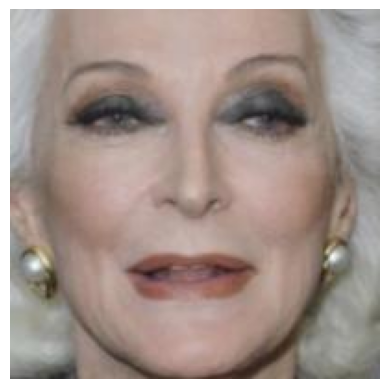

In [9]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

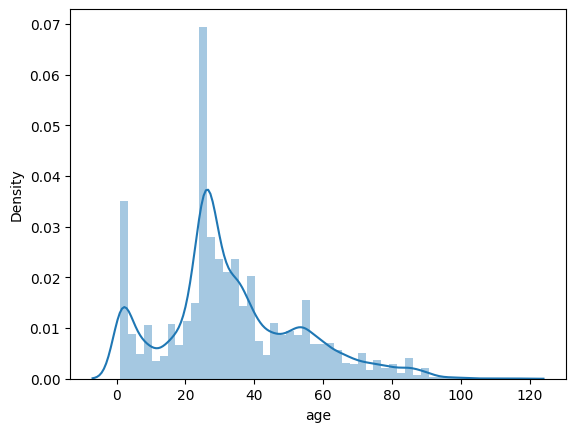

In [10]:
sns.distplot(df['age'])


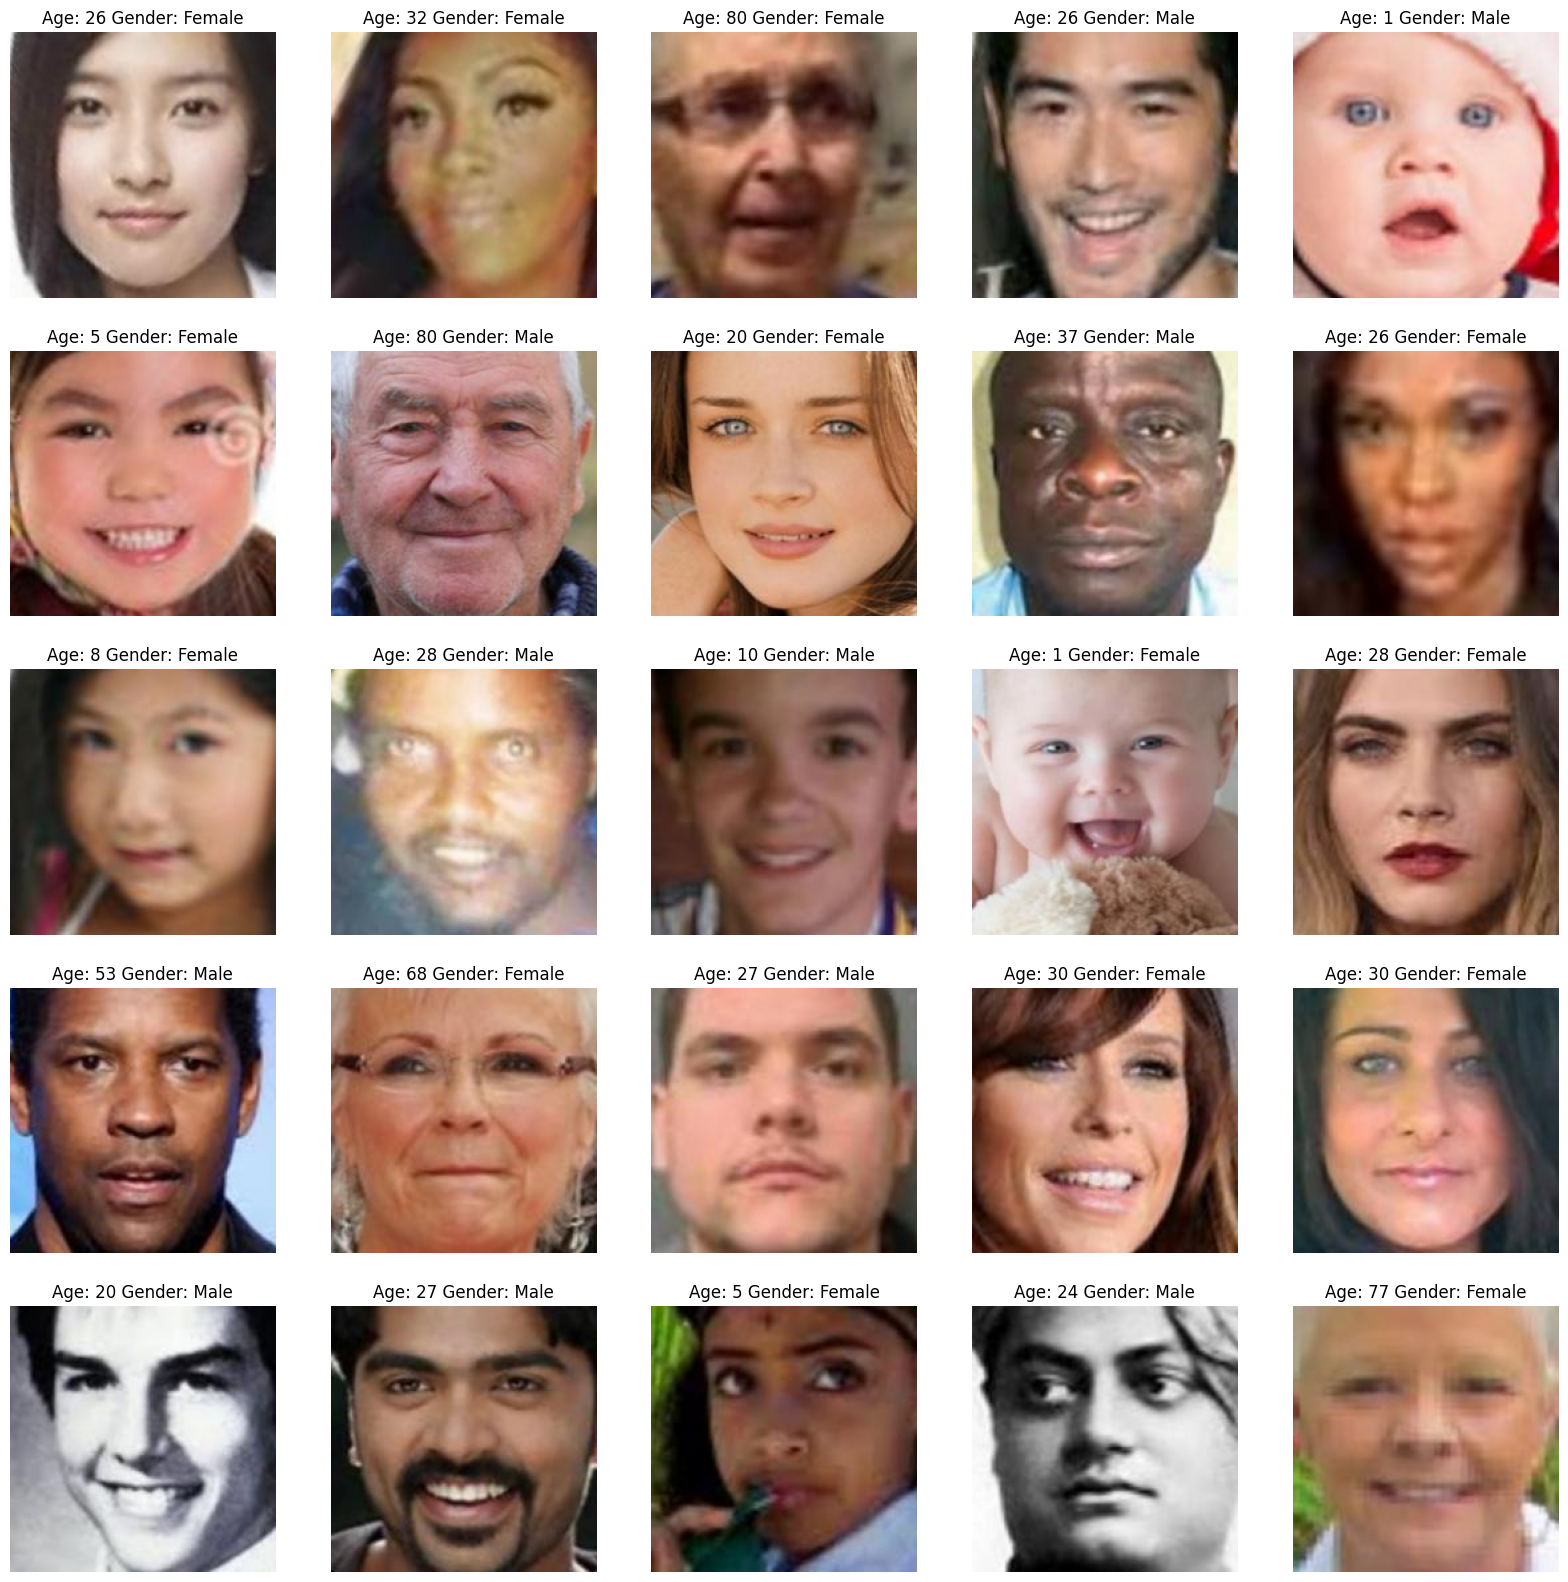

In [11]:
# to display grid of images
plt.figure(figsize=(20, 20))
#files = df.iloc[0:25]
random_files = df.sample(n=25)  # Randomly select 25 samples
random_files.reset_index(drop=True, inplace=True) # Reset index for consecutive numbering


for index, file, age, gender in random_files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:

X = extract_features(df['image'])

100%|██████████| 23858/23858 [02:25<00:00, 164.27it/s]


In [14]:
#print("sample feature :",X[0])
X.shape

(23858, 128, 128, 1)

In [15]:
# normalize the images
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128, 128, 1)

In [18]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test sets (80% train, 20% test)
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(X, y_gender, y_age, test_size=0.2, random_state=42)

# Further splitting train data into train and validation sets (80% train, 20% validation)
X_train, X_val, y_gender_train, y_gender_val, y_age_train, y_age_val = train_test_split(X_train, y_gender_train, y_age_train, test_size=0.2, random_state=42)

# Print the sizes of the splits
print("Train data size:", X_train.shape[0])
print("Validation data size:", X_val.shape[0])
print("Test data size:", X_test.shape[0])


Train data size: 15268
Validation data size: 3818
Test data size: 4772


In [19]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

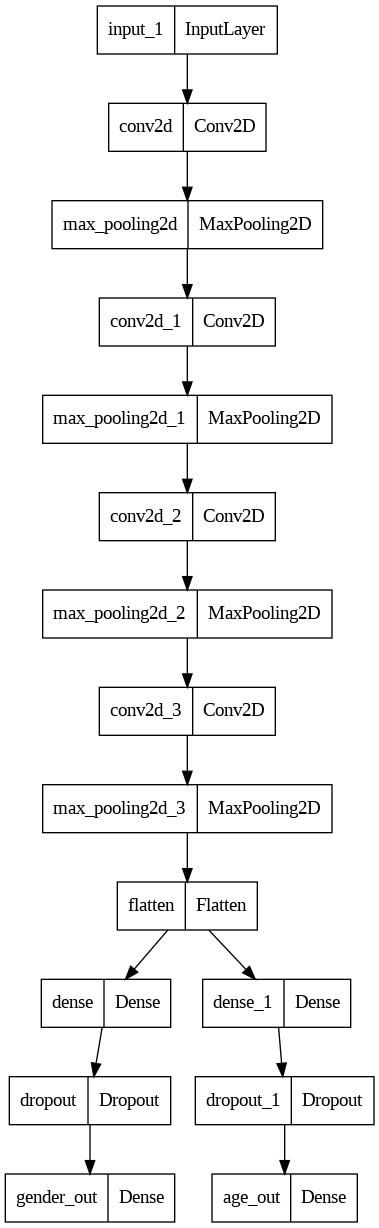

In [20]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [21]:
# Train model using train and validation data
history = model.fit(x=X_train, y=[y_gender_train, y_age_train], batch_size=32, epochs=30, validation_data=(X_val, [y_gender_val, y_age_val]))

# Evaluate model using test data
#test_results = model.evaluate(x=X_test, y=[y_gender_test, y_age_test])
#print("Test Loss:", test_results[0])
#print("Gender Test Accuracy:", test_results[1])
#print("Age Test MAE:", test_results[2])


Epoch 1/30
478/478 [==============================] - 652s 1s/step - loss: 16.6127 - gender_out_loss: 0.6993 - age_out_loss: 15.9135 - gender_out_accuracy: 0.5260 - gender_out_mae: 0.4973 - age_out_accuracy: 0.0448 - age_out_mae: 15.9135 - val_loss: 15.3317 - val_gender_out_loss: 0.6911 - val_age_out_loss: 14.6406 - val_gender_out_accuracy: 0.5089 - val_gender_out_mae: 0.4988 - val_age_out_accuracy: 0.0498 - val_age_out_mae: 14.6406
Epoch 2/30
478/478 [==============================] - 621s 1s/step - loss: 14.2779 - gender_out_loss: 0.6331 - age_out_loss: 13.6448 - gender_out_accuracy: 0.6328 - gender_out_mae: 0.4439 - age_out_accuracy: 0.0443 - age_out_mae: 13.6448 - val_loss: 11.8529 - val_gender_out_loss: 0.5142 - val_age_out_loss: 11.3387 - val_gender_out_accuracy: 0.7470 - val_gender_out_mae: 0.3494 - val_age_out_accuracy: 0.0437 - val_age_out_mae: 11.3387
Epoch 3/30
478/478 [==============================] - 620s 1s/step - loss: 11.7870 - gender_out_loss: 0.5174 - age_out_loss: 1

In [25]:
# Evaluate model using test data
test_results = model.evaluate(x=X_test, y=[y_gender_test, y_age_test])
print("Test Loss:", test_results[0])
print("Gender Test Accuracy:", test_results[3])
print("Age Test MAE:", test_results[6])

150/150 [==============================] - 50s 333ms/step - loss: 6.9881 - gender_out_loss: 0.2978 - age_out_loss: 6.6902 - gender_out_accuracy: 0.8879 - gender_out_mae: 0.1325 - age_out_accuracy: 0.0052 - age_out_mae: 6.6902
Test Loss: 6.98809289932251
Gender Test Accuracy: 0.8878876566886902
Age Test MAE: 6.690243721008301


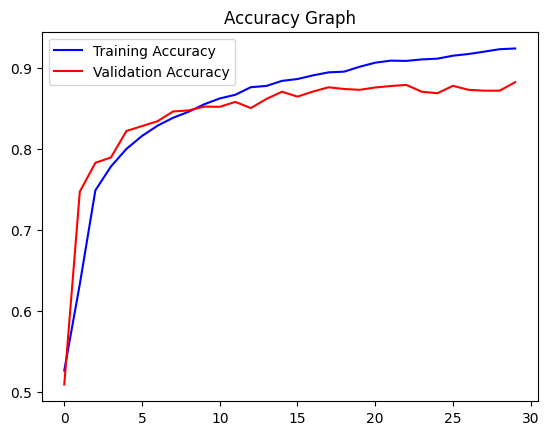

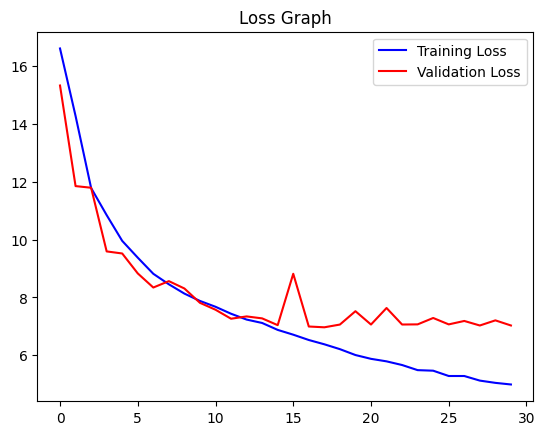

In [22]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

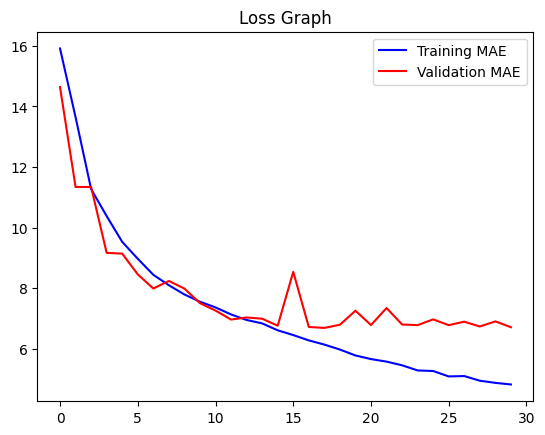

In [23]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()